# GRU

In [1]:
# 데이터 준비
from tensorflow.keras.datasets import imdb
import torch
import torch.nn.functional as F

VOCAB_SIZE = 300    # 사용할 단어 수
SEQ_LEN = 150       # 시퀀스 하나의 최대 길이

# 데이터 로드
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=VOCAB_SIZE)

# Torch Tensor 변환
train_input = [torch.tensor(seq, dtype=torch.long) for seq in train_input][:10000]
test_input = [torch.tensor(seq, dtype=torch.long) for seq in test_input][:5000]

train_target = torch.tensor(train_target, dtype=torch.long)[:10000]
test_target = torch.tensor(test_target, dtype=torch.long)[:5000]

# 패딩 처리
def pad_sequences(sequences, maxlen, padding_value=0):
    padded_sequences = [F.pad(seq[:maxlen], (0, max(0, maxlen-len(seq))), value=padding_value) for seq in sequences]
    return torch.stack(padded_sequences)

train_seq = pad_sequences(train_input, maxlen=SEQ_LEN)
test_seq = pad_sequences(test_input, maxlen=SEQ_LEN)

# 원핫인코딩 처리
train_onehot = F.one_hot(train_seq, num_classes=VOCAB_SIZE).float()
test_onehot = F.one_hot(test_seq, num_classes=VOCAB_SIZE).float()

# label 데이터 실수 처리
train_target = train_target.float()
test_target = test_target.float()

train_onehot.shape, test_onehot.shape

(torch.Size([10000, 150, 300]), torch.Size([5000, 150, 300]))

In [2]:
# 모델 학습 함수 정의
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

def train_func(train_data, train_label, model):
    # 학습을 위한 설정
    # 배치 사이즈, 학습/검증셋 크기 설정
    BATCH_SIZE = 65
    train_size = int(len(train_data) * 0.8)
    val_size = len(train_data) - train_size

    # 데이터 학습/검증셋 분할
    train_dataset, val_dataset = random_split(TensorDataset(train_data, train_label), [train_size, val_size])
    # 미니배치로 사용할 수 있도록 DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    # epoch(학습 횟수), 손실 함수, 최적화 함수 정의
    epochs = 100
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # 시각화를 위한 손실값/정확도 저장용 배열 생성 
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    # 조기종료 관련 변수 초기화
    early_stopping_patience = 7
    best_val_loss = float('inf')
    early_stop_counter = 0

    # 학습 진행
    for epoch in range(epochs):

        # 학습 모드
        model.train()
        total_loss, correct, total = 0, 0, 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()               # 가중치 초기화
            outputs = model(inputs).squeeze()   # 순전파

            loss = criterion(outputs, targets)  # 손실 계산

            loss.backward()                     # 역전파
            optimizer.step()                    # 가중치 갱신
            total_loss += loss.item()

            pred = (outputs > 0.5).float()
            correct += (pred == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # 검증 모드
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_outputs = model(val_inputs).squeeze()
                loss = criterion(val_outputs, val_targets)
                val_loss += loss.item()

                val_pred = (val_outputs > 0.5).float()
                val_correct += (val_pred == val_targets).sum().item()
                val_total += val_targets.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # 조기 종료
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stopping_patience:
                print("Early Stopping 할게~~~~~!")
                break

    # 학습 과정 시각화
    train_history_df = pd.DataFrame({
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accs,
        'val_acc': val_accs
    })

    train_history_df.plot()
    plt.show()

In [ ]:
import torch
import torch.nn as nn

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim, return_sequences=False, return_state=False):
        super(GRUModel, self).__init__()
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_units, batch_first=True)
        self.fc = nn.Linear(hidden_units, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hidden = self.gru(x)
        result_output = self.fc(hidden[-1])

        if self.return_sequences and self.return_state:
            return output, hidden[-1]
        elif self.return_sequences:
            return output
        elif self.return_state:
            return output[:, -1, :], hidden[-1]
        
        return self.sigmoid(result_output)

Epoch 1/100 | Train Loss: 0.6936, Train Acc: 0.5000, Val Loss: 0.6915, Val Acc: 0.5320
Epoch 2/100 | Train Loss: 0.6892, Train Acc: 0.5391, Val Loss: 0.6886, Val Acc: 0.5525
Epoch 3/100 | Train Loss: 0.6751, Train Acc: 0.5995, Val Loss: 0.6778, Val Acc: 0.5710
Epoch 4/100 | Train Loss: 0.5820, Train Acc: 0.6947, Val Loss: 0.5606, Val Acc: 0.7145
Epoch 5/100 | Train Loss: 0.5022, Train Acc: 0.7560, Val Loss: 0.5108, Val Acc: 0.7465
Epoch 6/100 | Train Loss: 0.4631, Train Acc: 0.7764, Val Loss: 0.4974, Val Acc: 0.7565
Epoch 7/100 | Train Loss: 0.4484, Train Acc: 0.7865, Val Loss: 0.4945, Val Acc: 0.7595
Epoch 8/100 | Train Loss: 0.4395, Train Acc: 0.7935, Val Loss: 0.5011, Val Acc: 0.7635
Epoch 9/100 | Train Loss: 0.4198, Train Acc: 0.8067, Val Loss: 0.4951, Val Acc: 0.7610
Epoch 10/100 | Train Loss: 0.4121, Train Acc: 0.8117, Val Loss: 0.5202, Val Acc: 0.7605
Epoch 11/100 | Train Loss: 0.3959, Train Acc: 0.8217, Val Loss: 0.5145, Val Acc: 0.7640
Epoch 12/100 | Train Loss: 0.3882, Train 

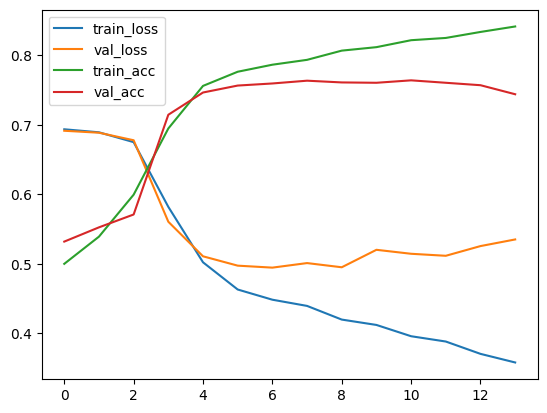

In [5]:
HIDDEN_DIM = 8
OUTPUT_DIM = 1

gru_model = GRUModel(
    input_dim=VOCAB_SIZE,
    hidden_units=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
)

train_func(train_onehot, train_target, gru_model)